In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input

from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from mlxtend.plotting import plot_confusion_matrix
import random
from imblearn.over_sampling import RandomOverSampler

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 769756660371745447
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17984379126583581030
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11701459968613090019
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15273553004510818159
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5645861010400145750
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6541641697824429513
physical_device_desc: "device: XLA_GPU device"
]
[]
2.3.1


## Reading Data 

In [3]:
labelsdf= pd.read_csv("worDwiseLabels/gt.csv")

In [4]:
labelsdf.head()

,File_name,Script,translation,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,word_1.png,Arabic,فروجنا,NaN,NaN,NaN,NaN
1,word_2.png,Arabic,المشوى,NaN,NaN,NaN,NaN
2,word_3.png,Arabic,حلال,NaN,NaN,NaN,NaN
3,word_4.png,Arabic,و,NaN,NaN,NaN,NaN
4,word_5.png,Arabic,طازج,NaN,NaN,NaN,NaN


In [5]:
(labelsdf['Script']).value_counts()

Latin       42629
Korean       4476
Japanese     4108
Arabic       3505
Bangla       3214
Chinese      2702
Symbols      1133
3               1
Name: Script, dtype: int64

In [6]:

labelsdf = labelsdf.dropna(axis=0, subset=['Script'])
labelsdf = labelsdf.dropna(axis=0, subset=['File_name'])
labelsdf=labelsdf[(labelsdf['Script'] !='Symbols')]
labelsdf=labelsdf[(labelsdf['Script'] !='3')]

Text(0.5, 1.0, 'number of images of each script')

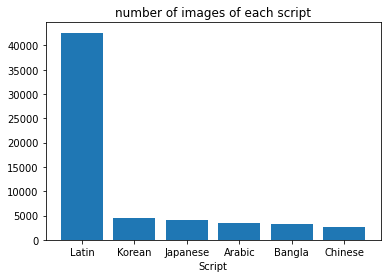

In [7]:
ab=labelsdf['Script'].value_counts()
plt.bar(ab.index,ab)
plt.xlabel('Script')
plt.title('number of images of each script')

### Balancing the imbalanced data by assigning weights to classes

##### We did weights optimization of classes using inverse frequencies of classes. We will then pass these weights to cost function of the model

In [8]:
class_index={0:'Arabic',1:'Bangla', 2:'Chinese', 3:'Japanese', 4:'Korean',5:'Latin'}
total=labelsdf['Script'].value_counts().sum()
vc=labelsdf['Script'].value_counts()
class_weights={val:total/vc[class_index[val]]for val in class_index}
class_weights

{0: 17.29928673323823,
 1: 18.865588052271313,
 2: 22.440414507772022,
 3: 14.75998052580331,
 4: 13.546470062555853,
 5: 1.4223650566515753}

### Splitting data into Train, Test and Validation

In [9]:
labelsdf_train = labelsdf.sample(frac = 0.85) 
labelsdf_test = labelsdf.drop(labelsdf_train.index)

labelsdf_train = labelsdf_train.reset_index()

In [10]:
labelsdf_test

,File_name,Script,translation,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
3,word_4.png,Arabic,و,NaN,NaN,NaN,NaN
18,word_19.png,Arabic,أعود,NaN,NaN,NaN,NaN
33,word_34.png,Arabic,العقبة,NaN,NaN,NaN,NaN
44,word_45.png,Arabic,دائرة,NaN,NaN,NaN,NaN
45,word_46.png,Arabic,التوظيف,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
61708,word_68553.png,Bangla,সোম,NaN,NaN,NaN,NaN
61713,word_68558.png,Bangla,সংহতি,NaN,NaN,NaN,NaN
61717,word_68562.png,Bangla,বেলঘরিয়া,NaN,NaN,NaN,NaN
61724,word_68569.png,Bangla,(পশ্চিমবঙ্গ,NaN,NaN,NaN,NaN


***

## Classification Report Plot function

In [10]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.summer):
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []

    for line in lines[2:(len(lines)-4)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)


    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            if row < len(classes) and column < len(matrix[0]):
                txt = matrix[row][column]
                ax.text(column,row,matrix[row][column],va='center',ha='center')

    
    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

## Generating Train, Test and Validation Iterator using Keras ImageDataGenerator

In [11]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15)
train_it=datagen.flow_from_dataframe(
dataframe=labelsdf_train,
directory="wordWise_Padded/",
x_col="File_name",
y_col="Script",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(128,128))

/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 318 invalid image filename(s) in x_col="File_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 43538 validated image filenames belonging to 6 classes.


In [12]:
val_it=datagen.flow_from_dataframe(
dataframe=labelsdf_train,
directory="wordWise_Padded/",
x_col="File_name",
y_col="Script",
subset="validation",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(128,128))

/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 318 invalid image filename(s) in x_col="File_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 7683 validated image filenames belonging to 6 classes.


In [11]:
testgen=ImageDataGenerator(rescale=1./255.)
test_it=testgen.flow_from_dataframe(
dataframe=labelsdf_test,
directory="wordWise_Padded/",
x_col="File_name",
y_col="Script",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(128,128))

Found 9033 validated image filenames belonging to 6 classes.


/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 62 invalid image filename(s) in x_col="File_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [14]:
freqClasses = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}

for x in test_it.classes:
    freqClasses[x] = freqClasses[x]+1
    
freqClasses

{0: 558, 1: 496, 2: 416, 3: 645, 4: 655, 5: 6276}

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def samplesMetrics(classes, y_pred, nSamples=30):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    allPredictions = pd.DataFrame(list(zip(classes, y_pred)), columns=['Classes', 'yPredicted'])

    for i in range(nSamples):

        labelsdf_Samples= allPredictions.sample(n=500)

        accuracy = accuracy_score(labelsdf_Samples['Classes'],labelsdf_Samples['yPredicted'])
        accuracies.append(accuracy)

        metrics = precision_recall_fscore_support(labelsdf_Samples['Classes'],labelsdf_Samples['yPredicted'],average='weighted')
        precisions.append(metrics[0])
        recalls.append(metrics[1])
        f1_scores.append(metrics[2])

    metricsEvaluated = {'Accuracy': accuracies,'Precision': precisions,'Recall': recalls, 'F1-Score': f1_scores}
    metricsDf = pd.DataFrame(metricsEvaluated)
    return metricsDf


def samplesMetricsFromModel(model,test_it):
    Y_pred = model.predict_generator(test_it) 
    y_pred = np.argmax(Y_pred, axis=1)
    metricsDf= samplesMetrics(test_it.classes, y_pred, nSamples=30)
    return  metricsDf


In [25]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


***

## CNN Base model

In [26]:
with strategy.scope():
    Basemodel = Sequential()

    Basemodel.add(Conv2D(32,(4, 4), activation='relu', input_shape=(128, 128, 3)))
    Basemodel.add(MaxPooling2D(pool_size=(3, 3)))

    Basemodel.add(Flatten())
    Basemodel.add(Dense(128, activation='relu'))
    Basemodel.add(Dense(6, activation='softmax'))

    Basemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 41, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 53792)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6885504   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 6,887,846
Trainable params: 6,887,846
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Basemodel.compile(loss = 'categorical_crossentropy',optimizer = Adam(lr = 0.001),metrics=['Recall','Precision','Accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
checkpoint = ModelCheckpoint('modelsPadded/modelSimple4.h5',save_best_only=True,monitor='val_loss')
modelHistory=Basemodel.fit(train_it,validation_data=val_it,epochs=50,callbacks=[es,checkpoint],class_weight=class_weights)

Epoch 1/50
1369/1369 [==============================] - 194s 142ms/step - loss: 1.0266 - recall: 0.8684 - precision: 0.8988 - accuracy: 0.0166 - val_loss: 1.5319 - val_recall: 0.6942 - val_precision: 0.7265 - val_accuracy: 0.0097
Epoch 2/50
1369/1369 [==============================] - 194s 142ms/step - loss: 0.9168 - recall: 0.8856 - precision: 0.9130 - accuracy: 0.0182 - val_loss: 1.5196 - val_recall: 0.7058 - val_precision: 0.7401 - val_accuracy: 0.0133
Epoch 3/50
1369/1369 [==============================] - 193s 141ms/step - loss: 0.8427 - recall: 0.8934 - precision: 0.9185 - accuracy: 0.0228 - val_loss: 1.7000 - val_recall: 0.6457 - val_precision: 0.6835 - val_accuracy: 0.0088
Epoch 4/50
1369/1369 [==============================] - 195s 142ms/step - loss: 0.7872 - recall: 0.9021 - precision: 0.9251 - accuracy: 0.0227 - val_loss: 1.6510 - val_recall: 0.7111 - val_precision: 0.7346 - val_accuracy: 0.0135
Epoch 5/50
1369/1369 [==============================] - 192s 140ms/step - loss: 

In [15]:
modelBase = keras.models.load_model("modelsPadded/modelSimple4.h5")

In [17]:
score = modelBase.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.616091787815094
Test accuracy: 0.8341808319091797


In [18]:
Y_pred = modelBase.predict_generator(test_it) 
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


### Confusion Matrix and Classification Report


In [19]:
cm=confusion_matrix(test_it.classes, y_pred)
cm

array([[ 504,    2,    3,    5,    6,   38],
       [   3,  447,    5,    3,    9,   29],
       [   3,    1,  366,   14,    2,   30],
       [   4,    8,   41,  530,   10,   52],
       [  17,    7,   15,   10,  568,   38],
       [ 201,  199,  197,  161,  238, 5280]])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

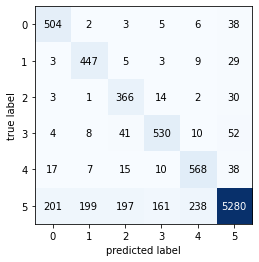

In [20]:
plot_confusion_matrix(cm)

In [21]:
basemodel_cr = classification_report(test_it.classes, y_pred)
print(basemodel_cr)

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       558
           1       0.67      0.90      0.77       496
           2       0.58      0.88      0.70       416
           3       0.73      0.82      0.77       645
           4       0.68      0.87      0.76       655
           5       0.97      0.84      0.90      6276

    accuracy                           0.85      9046
   macro avg       0.72      0.87      0.78      9046
weighted avg       0.88      0.85      0.86      9046



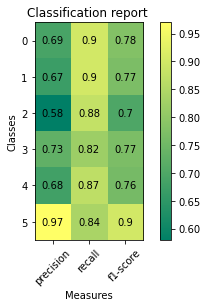

In [22]:
bm_cr = """precision    recall  f1-score   support

           0       0.69      0.90      0.78       558
           1       0.67      0.90      0.77       496
           2       0.58      0.88      0.70       416
           3       0.73      0.82      0.77       645
           4       0.68      0.87      0.76       655
           5       0.97      0.84      0.90      6276

    accuracy                           0.85      9046
   macro avg       0.72      0.87      0.78      9046
weighted avg       0.88      0.85      0.86      9046"""

plot_classification_report(bm_cr)

In [15]:
model = keras.models.load_model("modelsPadded/modelSimple4.h5")   
metricsDf = samplesMetricsFromModel(model,test_it)
metricsDf.to_csv("SingleCNN_Padded.csv")
metricsDf

Instructions for updating:
Please use Model.predict, which supports generators.


,Accuracy,Precision,Recall,F1-Score
0,0.842,0.873536,0.842,0.849389
1,0.836,0.885183,0.836,0.848402
2,0.844,0.881999,0.844,0.853372
3,0.852,0.890790,0.852,0.861331
4,0.860,0.889115,0.860,0.866805
5,0.840,0.877007,0.840,0.850213
6,0.854,0.877070,0.854,0.860332
7,0.850,0.879491,0.850,0.857278
8,0.836,0.853871,0.836,0.840931
9,0.876,0.904002,0.876,0.881876


In [18]:
def getAvgStd(csvFile,column='F1-Score'):
    df= pd.read_csv(csvFile)
    avg=np.mean(df[column])
    std=np.std(df[column])
    return avg,std
    
avg, std = getAvgStd("SingleCNN_Padded.csv")
print("Mean = ", avg)
print("Standard Deviation = ", std)

Mean =  0.8616685304243465
Standard Deviation =  0.011753082780668233


***

## Inception Model

In [27]:
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

In [28]:
   
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape= (128,128,3))
x = Inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation= 'softmax')(x)
Inceptionmodel = Model(inputs = Inception_model.input, outputs =predictions )

In [29]:
Inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 6, 6, 160)    179200      activation_54[0][0]              
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 6, 6, 160)    480         conv2d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 6, 6, 160)    0           batch_normalization_55[0][0]     
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 6, 6, 160)    122880      mixed5[0][0]                     
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 6, 6, 160)    179200      activation_55[0][0]              
__________

Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [30]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001)
Inceptionmodel.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['Recall','Precision','Accuracy'])

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
checkpoint = ModelCheckpoint('models/modelinception3.h5',save_best_only=True,monitor='val_loss')
historyInc=Inceptionmodel.fit(train_it,validation_data=val_it,steps_per_epoch=32,epochs=120,callbacks=[es,checkpoint])

Epoch 1/120
32/32 [==============================] - 468s 15s/step - loss: 1.1953 - recall: 0.6045 - precision: 0.7449 - accuracy: 0.0000e+00 - val_loss: 262.6605 - val_recall: 0.7001 - val_precision: 0.7001 - val_accuracy: 0.7930
Epoch 2/120
32/32 [==============================] - 456s 14s/step - loss: 1.0403 - recall: 0.6211 - precision: 0.7970 - accuracy: 0.0000e+00 - val_loss: 11483.7910 - val_recall: 0.0534 - val_precision: 0.0534 - val_accuracy: 0.6844
Epoch 3/120
32/32 [==============================] - 463s 14s/step - loss: 0.9769 - recall: 0.6182 - precision: 0.8115 - accuracy: 0.0000e+00 - val_loss: 42.0888 - val_recall: 0.1160 - val_precision: 0.1925 - val_accuracy: 0.1183
Epoch 4/120
32/32 [==============================] - 460s 14s/step - loss: 0.8797 - recall: 0.6406 - precision: 0.8241 - accuracy: 0.0000e+00 - val_loss: 1.1796 - val_recall: 0.6950 - val_precision: 0.7130 - val_accuracy: 5.2063e-04
Epoch 5/120
32/32 [==============================] - 460s 14s/step - loss

32/32 [==============================] - 687s 21s/step - loss: 0.4665 - recall: 0.7871 - precision: 0.8996 - accuracy: 0.0000e+00 - val_loss: 0.5057 - val_recall: 0.8037 - val_precision: 0.8857 - val_accuracy: 0.0000e+00
Epoch 72/120
32/32 [==============================] - 556s 17s/step - loss: 0.4374 - recall: 0.8018 - precision: 0.8939 - accuracy: 0.0000e+00 - val_loss: 0.5017 - val_recall: 0.8221 - val_precision: 0.8677 - val_accuracy: 0.0138
Epoch 73/120
32/32 [==============================] - 549s 17s/step - loss: 0.4000 - recall: 0.8379 - precision: 0.8984 - accuracy: 0.0000e+00 - val_loss: 0.5188 - val_recall: 0.7972 - val_precision: 0.8674 - val_accuracy: 2.1693e-05
Epoch 74/120
32/32 [==============================] - 557s 17s/step - loss: 0.4715 - recall: 0.8008 - precision: 0.8884 - accuracy: 0.0000e+00 - val_loss: 0.7524 - val_recall: 0.7739 - val_precision: 0.8213 - val_accuracy: 0.0000e+00
Epoch 75/120
32/32 [==============================] - 619s 19s/step - loss: 0.464

In [38]:
Inceptionmodel = keras.models.load_model("models/modelinception3.h5")

In [39]:
score = Inceptionmodel.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test recall:', score[1])

Test loss: 0.4121626317501068
Test recall: 0.8070078492164612


In [40]:
Y_predInception = Inceptionmodel.predict(test_it) 
Y_predInception = np.argmax(Y_predInception, axis=1)


### Confusion Matrix and Classification Report


In [41]:
inception_cm=confusion_matrix(test_it.classes, Y_predInception)
inception_cm

array([[ 418,    4,    1,    2,   23,   86],
       [   2,  371,    1,    1,    6,   72],
       [   0,    2,  139,  183,   26,   69],
       [   3,   12,   99,  188,   84,  207],
       [   2,    3,    3,   21,  490,  141],
       [  45,   49,   35,   50,   64, 6145]])

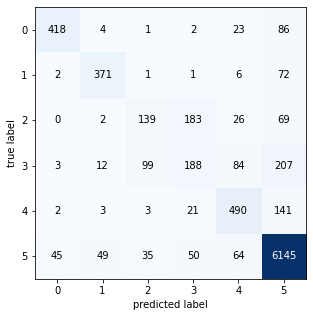

In [42]:
plot_confusion_matrix(inception_cm,figsize=(5,5))
plt.show()

In [43]:
inception_cr = classification_report(test_it.classes, Y_predInception)
print(inception_cr)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       534
           1       0.84      0.82      0.83       453
           2       0.50      0.33      0.40       419
           3       0.42      0.32      0.36       593
           4       0.71      0.74      0.72       660
           5       0.91      0.96      0.94      6388

    accuracy                           0.86      9047
   macro avg       0.71      0.66      0.68      9047
weighted avg       0.84      0.86      0.85      9047



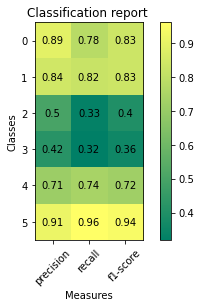

In [44]:
inception_Cr = """ precision    recall  f1-score   support

           0       0.89      0.78      0.83       534
           1       0.84      0.82      0.83       453
           2       0.50      0.33      0.40       419
           3       0.42      0.32      0.36       593
           4       0.71      0.74      0.72       660
           5       0.91      0.96      0.94      6388

    accuracy                           0.86      9047
   macro avg       0.71      0.66      0.68      9047
weighted avg       0.84      0.86      0.85      9047"""

plot_classification_report(inception_Cr)

In [16]:
model = keras.models.load_model("models/modelinception3.h5")   
metricsDf = samplesMetricsFromModel(model,test_it)
metricsDf.to_csv("InceptionV3_Padded.csv")
metricsDf

,Accuracy,Precision,Recall,F1-Score
0,0.888,0.880759,0.888,0.879920
1,0.868,0.856854,0.868,0.858856
2,0.878,0.864249,0.878,0.867757
3,0.864,0.847986,0.864,0.852402
4,0.860,0.848197,0.860,0.848024
5,0.874,0.864151,0.874,0.865245
6,0.880,0.866707,0.880,0.870902
7,0.886,0.872592,0.886,0.876895
8,0.872,0.860611,0.872,0.862777
9,0.872,0.858398,0.872,0.862275


In [19]:
def getAvgStd(csvFile,column='F1-Score'):
    df= pd.read_csv(csvFile)
    avg=np.mean(df[column])
    std=np.std(df[column])
    return avg,std
    
avg, std = getAvgStd("InceptionV3_Padded.csv")
print("Mean = ", avg)
print("Standard Deviation = ", std)

Mean =  0.8564472963939896
Standard Deviation =  0.012067550042905129
